ゴールに到達しました。


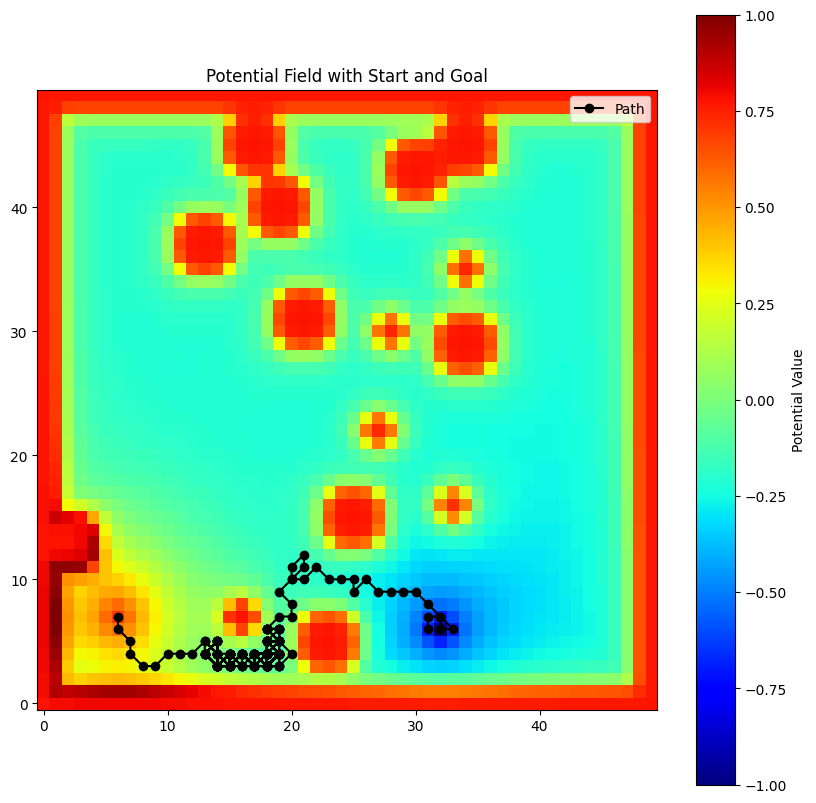

(7, 6)
(6, 32)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter

np.set_printoptions(
    threshold=np.inf,  # 配列の省略を無効化
    formatter={'float_kind': lambda x: f"{x:.6f}"}  # 小数点6桁に統一

)

def generate_map(size, obstacle_count, large_obstacle_count, large_obstacle_size, safe_distance):

    grid = np.zeros((size, size))
    start = (random.randint(1, size - 2), random.randint(1, size - 2)) # スタート位置を設定(壁の内側から選択)
    goal = (random.randint(1, size - 2), random.randint(1, size - 2)) # ゴール位置を設定(壁の内側から選択)
    while goal == start:
        goal = (random.randint(1, size - 2), random.randint(1, size - 2))

    safe_distance_squared = safe_distance ** 2 # 距離計算を効率化するため二乗で比較

    # 壁を追加
    walls = set()
    for i in range(size):
        walls.add((0, i)) # 上の壁
        walls.add((size - 1, i)) # 下の壁
        walls.add((i, 0)) # 左の壁
        walls.add((i, size - 1)) # 右の壁

    # 大きめの障害物を設置
    large_obstacles = set()
    for _ in range(large_obstacle_count):
        x_start = random.randint(1, size - large_obstacle_size - 1)
        y_start = random.randint(1, size - large_obstacle_size - 1)
        for dx in range(large_obstacle_size):
            for dy in range(large_obstacle_size):
                large_obstacles.add((x_start + dx, y_start + dy))

    # 小さめの障害物を追加
    obstacles = set()
    while len(obstacles) < obstacle_count:
        obs = (random.randint(1, size - 2), random.randint(1, size - 2)) # 壁を避けた範囲
        if obs not in large_obstacles:
            obstacles.add(obs)

    # 全ての障害物を統合
    all_obstacles = walls | large_obstacles | obstacles

    # スタート位置を決定(安全距離を考慮)
    while True:
        start = (random.randint(1, size - 2), random.randint(1, size - 2))
        if all(np.linalg.norm(np.array(start) - np.array(obs)) >= safe_distance for obs in all_obstacles):
            break

    # ゴール位置を決定(安全距離を考慮)
    while True:
        goal = (random.randint(1, size - 2), random.randint(1, size - 2))
        if goal != start and all(np.linalg.norm(np.array(goal) - np.array(obs)) >= safe_distance for obs in all_obstacles):
            break

    # グリッドに障害物を反映
    for obs in all_obstacles:
        grid[obs] = max_potential

    return grid, start, goal, all_obstacles

def compute_potential_field(grid, start, goal, obstacles, max_potential, min_potential, sigma):

    size = grid.shape[0]
    potential_field = np.zeros_like(grid, dtype=float)

    # スタートのポテンシャル設定
    for x in range(size):
        for y in range(size):
            d_start = np.linalg.norm(np.array([x, y]) - np.array(start))
            potential_field[x, y] += max_potential * np.exp(-d_start / 5.0) # 距離に応じた減衰(調整可能)

    # ゴールのポテンシャル設定
    potential_field[goal] = min_potential

    # 障害物や壁のポテンシャルを設定
    for obs in obstacles:
        potential_field[obs] = max_potential

    # 他のポテンシャル(ゴールと障害物の影響)を計算
    for x in range(size):
        for y in range(size):
            if (x, y) == start or (x, y) == goal or (x, y) in obstacles:
                continue
            d_goal = np.linalg.norm(np.array([x, y]) - np.array(goal))
            d_obstacles = min([np.linalg.norm(np.array([x, y]) - np.array(obs)) for obs in obstacles])

            # ゴールの引力と障害物の斥力を調整
            attraction = -1 / (1 + d_goal) # ゴールへの引力
            repulsion = 1 / (d_obstacles + 1e-5) ** 2 # 障害物の斥力(より急激に減衰)
            potential_field[x, y] += attraction + repulsion

    # スムージングを適用
    potential_field = gaussian_filter(potential_field, sigma=sigma) # sigmaを小さくして斥力を局所化

    # 正規化
    potential_field = (potential_field - np.min(potential_field)) / (np.max(potential_field) - np.min(potential_field))

    return potential_field * 2 - 1  # [-1, 1] にスケーリング

def plan_path(potential_field, start, goal, map_size, step_size, tolerance):

    current_position = np.array(start, dtype=float)
    path = [start]
    velocity = np.array([0.0, 0.0])
    max_iterations = 1000  # 最大試行回数

    for _ in range(max_iterations):
        # ゴール判定
        if np.linalg.norm(current_position - np.array(goal)) < tolerance:
            print("ゴールに到達しました。")
            break

        # 現在位置の勾配を計算
        x, y = int(current_position[0]), int(current_position[1])
        grad_x = potential_field[min(x + 1, map_size - 1), y] - potential_field[max(x - 1, 0), y]
        grad_y = potential_field[x, min(y + 1, map_size - 1)] - potential_field[x, max(y - 1, 0)]
        gradient = np.array([grad_x, grad_y])

        # 速度と位置の更新
        acceleration = -gradient / np.linalg.norm(gradient + 1e-5)  # 正規化
        velocity = velocity * 0.9 + acceleration  # 慣性を加味
        velocity = velocity / np.linalg.norm(velocity + 1e-5) * step_size  # 正規化してステップサイズ適用
        current_position += velocity

        # 境界条件を適用
        current_position = np.clip(current_position, 0, map_size - 1)
        path.append(tuple(current_position.astype(int)))

        # 停止条件：速度が非常に小さい場合
        if np.linalg.norm(velocity) < 1e-2:
            print("速度が低下したため終了します。")
            break
    else:
        print("最大試行回数に達しました。")

    return path

def plot_environment(grid, start, goal, obstacles, output_path):

    # 行列のサイズを取得
    height, width = grid.shape

    # 図と軸を作成(行列サイズに合わせたピクセル数を設定)
    dpi = 100  # 解像度を設定
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)

    # 環境マップを描画
    ax = fig.add_axes([0, 0, 1, 1])  # 余白なしでプロット
    ax.imshow(grid, cmap="gray_r", origin="lower")
    ax.scatter(start[1], start[0], color='green', label='Start', s=100, edgecolor='black')
    ax.scatter(goal[1], goal[0], color='red', label='Goal', s=100, edgecolor='black')
    for obs in obstacles:
        ax.scatter(obs[1], obs[0], color='black', s=10)  # 障害物をプロット
    ax.axis("off")  # 軸を非表示にする

    # 画像として保存(余白なし)
    fig.savefig(output_path, dpi=dpi, bbox_inches="tight", pad_inches=0)

    # 後処理
    plt.close(fig)

def plot_potential_field(potential_field, output_path, cmap="jet"):

    # 行列のサイズを取得
    height, width = potential_field.shape

    # 図と軸を作成(行列サイズに合わせたピクセル数を設定)
    dpi = 100  # 解像度を設定
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)

    # ヒートマップを描画
    ax = fig.add_axes([0, 0, 1, 1])  # 余白なしでプロット
    ax.imshow(potential_field, cmap=cmap, origin="lower", interpolation="none")  # 1:1でピクセルマッピング
    ax.axis("off")  # 軸を非表示にする

    # 画像として保存(余白なし)
    fig.savefig(output_path, dpi=dpi, bbox_inches="tight", pad_inches=0)

    # 後処理
    plt.close(fig)

def plot_pathplan(potential_field, start, goal, path, output_path):

    plt.figure(figsize=(10, 10))
    # plt.imshow(potential_field, cmap="coolwarm", origin="lower")
    plt.imshow(potential_field, cmap="jet", origin="lower")
    plt.colorbar(label="Potential Value")

    # 経路をプロット
    if path:
        path = np.array(path)
        plt.plot(path[:, 1], path[:, 0], marker='o', color='black', label='Path')

    plt.title("Potential Field with Start and Goal")
    plt.legend()
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0)

    plt.show()

if __name__=='__main__':

    num = 1 # 作成するデータの数

    # 環境マップの設定
    map_size = 50  # マップのサイズ
    obstacle_count = 5  # 小さめの障害物の数
    large_obstacle_count = 10 # 大きめの障害物の数
    large_obstacle_size = 3 # 大きめの障害物のサイズ
    safe_distance = 5

    # ポテンシャルフィールドの設定
    max_potential = 1.0
    min_potential = -1.0
    sigma = 0.5

    # ロボットの移動パラメータ
    step_size = 1.0  # ロボットのステップサイズ
    tolerance = 0.5  # ゴールに到達する許容距離

    # メイン処理
    for i in range(num):

        map_path = "./env_" + str(i) + ".png"
        pot_path = "./pot_" + str(i) + ".png"
        out_path = "./plan_" + str(i) + ".png"

        grid, start, goal, obstacles = generate_map(map_size, obstacle_count, large_obstacle_count, large_obstacle_size, safe_distance) # 環境マップを作成
        potential_field = compute_potential_field(grid, start, goal, obstacles, max_potential, min_potential, sigma) # ポテンシャルフィールドを計算
        path = plan_path(potential_field, start, goal, map_size, step_size, tolerance) # 経路計画

        plot_environment(grid, start, goal, obstacles, map_path) # 環境マップを可視化
        plot_potential_field(potential_field, pot_path) # ポテンシャルフィールドを可視化
        plot_pathplan(potential_field, start, goal, path, out_path) # ヒートマップの表示と経路を可視化

        # path_w = 'pot.txt'
        # with open(path_w, mode='w') as f:
        #     f.write(np.array2string(potential_field))
    print(start)
    print(goal)

ゴールに到達しました。
[(7, 6), (6, 6), (5, 7), (4, 7), (3, 8), (3, 9), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (3, 16), (3, 17), (4, 18), (4, 19), (5, 18), (4, 19), (3, 18), (4, 17), (3, 17), (4, 16), (3, 15), (4, 14), (3, 15), (3, 16), (4, 17), (4, 18), (3, 19), (4, 19), (5, 19), (5, 18), (4, 17), (3, 18), (4, 19), (5, 18), (5, 19), (6, 19), (6, 18), (6, 19), (5, 18), (4, 19), (3, 18), (4, 17), (3, 17), (4, 16), (3, 15), (4, 14), (3, 15), (3, 16), (4, 17), (3, 18), (4, 18), (4, 19), (4, 18), (3, 18), (4, 18), (5, 19), (6, 18), (6, 19), (7, 19), (8, 19), (9, 20), (10, 20), (10, 21), (11, 21), (11, 20), (10, 21), (11, 22), (10, 23), (9, 24), (10, 25), (10, 26), (10, 27), (9, 27), (9, 28), (8, 29), (8, 30), (7, 31), (7, 32), (6, 32), (6, 33), (7, 33), (7, 32), (7, 31), (6, 31)]


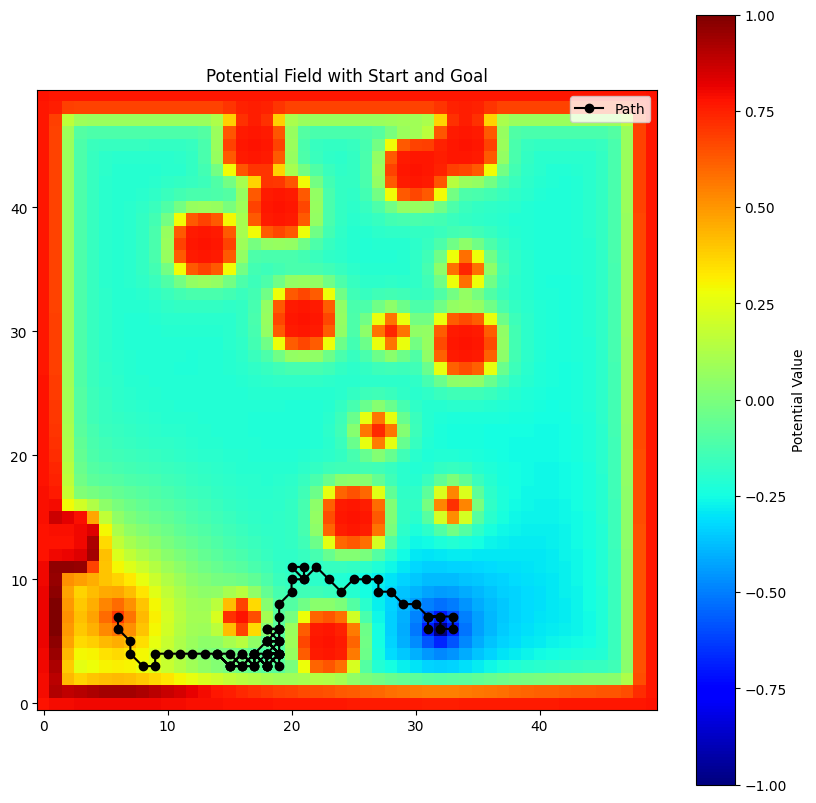

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from PIL import Image

# 画像からポテンシャルフィールドを復元
def load_potential_field_from_heatmap(image_path, cmap_name="jet", vmin=-1, vmax=1):

    # ヒートマップ画像を読み込み
    image = Image.open(image_path).convert("RGB")
    image_data = np.array(image)

    # カラーマップを取得
    cmap = plt.get_cmap(cmap_name)
    norm = Normalize(vmin=vmin, vmax=vmax)

    # カラーマップの逆変換を準備
    scalar_mappable = ScalarMappable(norm=norm, cmap=cmap)

    # ピクセル値をカラーマップのインデックスに変換
    normalized_values = scalar_mappable.to_rgba(np.linspace(vmin, vmax, 256))[:, :3]
    color_to_value = {tuple((normalized_values[i] * 255).astype(int)): vmin + i * (vmax - vmin) / 255 for i in range(256)}

    # ピクセルをスキャンしてポテンシャル値に変換
    field = np.zeros((image_data.shape[0], image_data.shape[1]))
    for x in range(image_data.shape[0]):
        for y in range(image_data.shape[1]):
            color = tuple(image_data[x, y])
            field[x, y] = color_to_value[color]

    field = np.flipud(field)

    return field

def plan_path(potential_field, start, goal, map_size, step_size, tolerance):

    current_position = np.array(start, dtype=float)
    path = [start]
    velocity = np.array([0.0, 0.0])
    max_iterations = 1000  # 最大試行回数

    for _ in range(max_iterations):
        # ゴール判定
        if np.linalg.norm(current_position - np.array(goal)) < tolerance:
            print("ゴールに到達しました。")
            break

        # 現在位置の勾配を計算
        x, y = int(current_position[0]), int(current_position[1])
        grad_x = potential_field[min(x + 1, map_size - 1), y] - potential_field[max(x - 1, 0), y]
        grad_y = potential_field[x, min(y + 1, map_size - 1)] - potential_field[x, max(y - 1, 0)]
        gradient = np.array([grad_x, grad_y])

        # 速度と位置の更新
        acceleration = -gradient / np.linalg.norm(gradient + 1e-5)  # 正規化
        velocity = velocity * 0.9 + acceleration  # 慣性を加味
        velocity = velocity / np.linalg.norm(velocity + 1e-5) * step_size  # 正規化してステップサイズ適用
        current_position += velocity

        # 境界条件を適用
        current_position = np.clip(current_position, 0, map_size - 1)
        path.append(tuple(current_position.astype(int)))

        # 停止条件：速度が非常に小さい場合
        if np.linalg.norm(velocity) < 1e-2:
            print("速度が低下したため終了します。")
            break
    else:
        print("最大試行回数に達しました。")

    return path

def plot_potential_field(potential_field, start, goal, path=None):

    plt.figure(figsize=(10, 10))
    # plt.imshow(potential_field, cmap="coolwarm", origin="lower")
    plt.imshow(potential_field, cmap="jet", origin="lower")
    plt.colorbar(label="Potential Value")

    # 経路をプロット
    if path:
        path = np.array(path)
        plt.plot(path[:, 1], path[:, 0], marker='o', color='black', label='Path')

    plt.title("Potential Field with Start and Goal")
    plt.legend()
    plt.show()

if __name__=='__main__':

    # 環境マップの設定
    map_size = 50  # マップのサイズ
    obstacle_count = 5  # 小さめの障害物の数
    large_obstacle_count = 10 # 大きめの障害物の数
    large_obstacle_size = 3 # 大きめの障害物のサイズ
    safe_distance = 5

    # ポテンシャルフィールドの設定
    max_potential = 1.0
    min_potential = -1.0
    sigma = 0.5

    # ロボットの移動パラメータ
    step_size = 1.0  # ロボットのステップサイズ
    tolerance = 0.5  # ゴールに到達する許容距離

    start = (7, 6)
    goal = (6, 32)

    image_path = "pot_0.png" # 保存したヒートマップ画像のパス
    recovered_potential_field = load_potential_field_from_heatmap(image_path, vmin=min_potential, vmax=max_potential)

    # ポテンシャルフィールドを保存（テキスト形式）
    # path_w = 'pot2.txt'
    # with open(path_w, mode='w') as f:
    #     f.write(np.array2string(recovered_potential_field))

    path = plan_path(recovered_potential_field, start, goal, map_size, step_size, tolerance) # 経路計画
    print(path)
    plot_potential_field(recovered_potential_field, start, goal, path) # ヒートマップの表示と経路を可視化
